In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn.cluster import DBSCAN


#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

## Intro



## Data

Our data set consists out of all the apartment deals made in Helsinki during the last 12 months. The data contains variables: apartment type, apartment size in $m^2$, neighborhood, price, number of rooms, year built, floor number, elevator, condition and neighborhood. We scarped the data from \url{http://asuntojen.hintatiedot.fi/haku/}. Also we enriched the data by adding location coordinates for each neighborhood and calculating the neighborhood's distance from Helsinki city center. Coordinates we fetched using Google maps API. 

-- Miten putsattiin data? - lukee sharelatex filussa

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head

In [27]:
data, data_with_neighborhood = utils.load_data('data/cleaned_data2.csv')
data.head(5)

,type_kt,type_rt,type_ok,elevator,price,price_per_square_meter,number_of_rooms,square_meters,year,condition,floor_num,top_floor,bottom_floor,floor_frac,lat,lng,dist_center
0,1,0,0,1,191050,10055,1,19.0,1929,2,5.0,True,False,1.000000,60.167458,24.931075,0.485608
1,1,0,0,0,143000,5789,1,24.7,1957,1,3.0,False,False,0.750000,60.206704,24.871212,5.544540
2,1,0,0,1,167000,6680,1,25.0,1940,1,6.0,True,False,1.000000,60.188258,24.955949,2.270341
3,1,0,0,0,157000,6181,1,25.4,1951,1,1.0,False,False,0.250000,60.202747,24.905494,4.093763
4,1,0,0,0,133000,4926,1,27.0,1961,2,2.0,False,False,0.666667,60.212173,25.096109,9.939839


## Data exploration
In this section we explore the data to get a better understanding of it

### Plot variables
Next, we plot some variables to get a feel for the dataset. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y axis

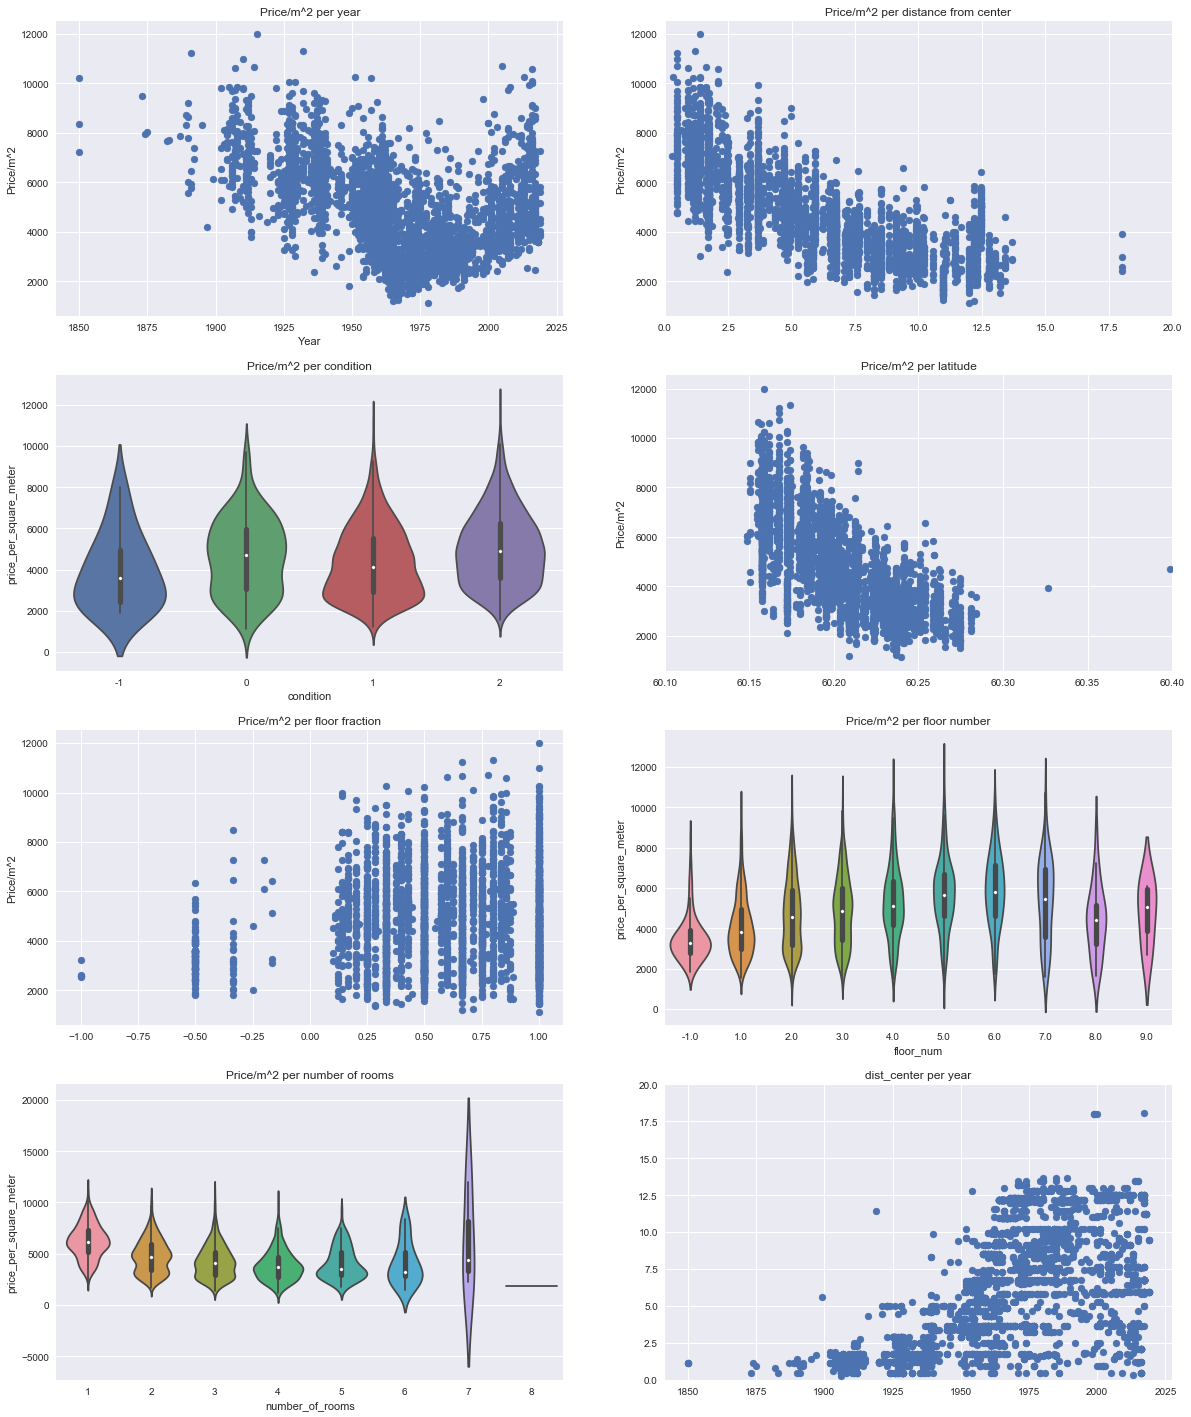

In [28]:
utils.plot_variables(data)

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. Year and distance from city center also correlate.

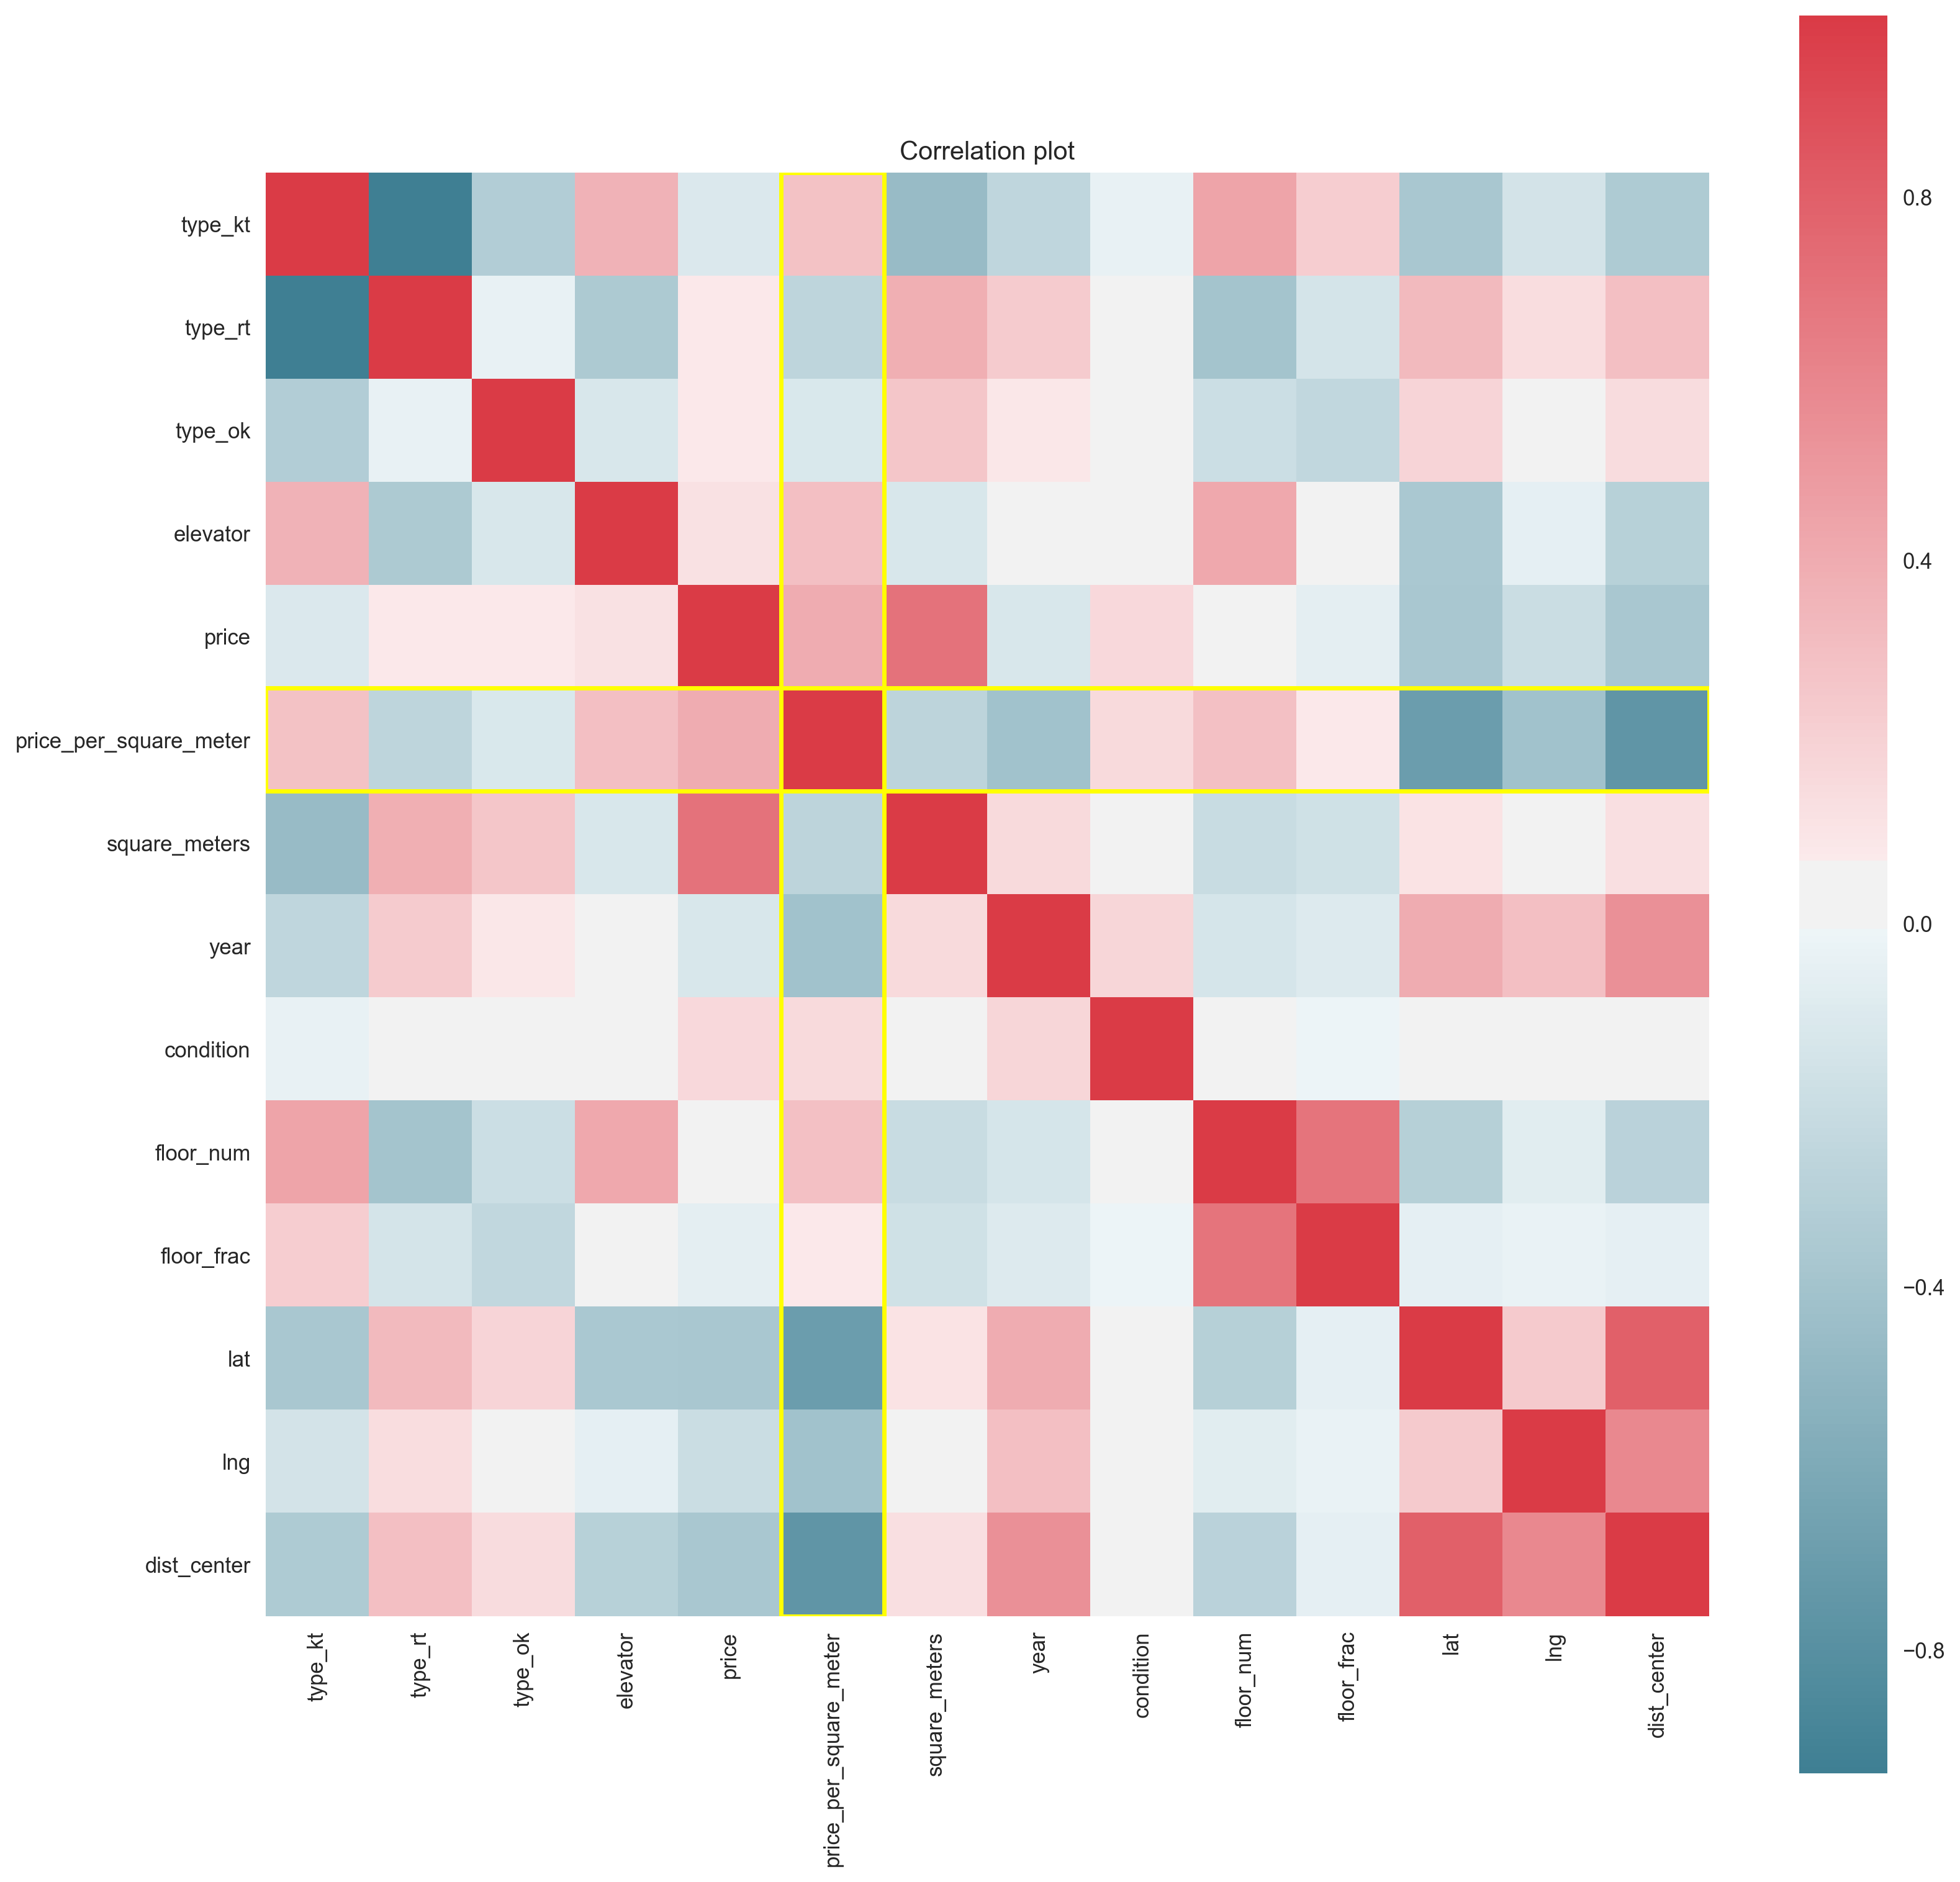

In [29]:
utils.plot_correlation(data)

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

The resulting plots show somewhat neat clusters. In the bottom row, they are colored based on kmeans and DBSCAN clustering algorithm. For example, it seems that the top left cluster represents new houses in good condition. The two clusters on the right represent older houses in varying conditions near the center of the city.

The results suggest that neighbor or distance based models might perform well on this task. 

In [6]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

In [7]:
# Calculate kmeans and spectral clusters on the data for cluster visualization
kmeans = KMeans(n_clusters=8).fit(data_tsne_embedded)
kmeans_labels = kmeans.labels_

dbscan_labels = DBSCAN(eps=3).fit_predict(data_tsne_embedded)

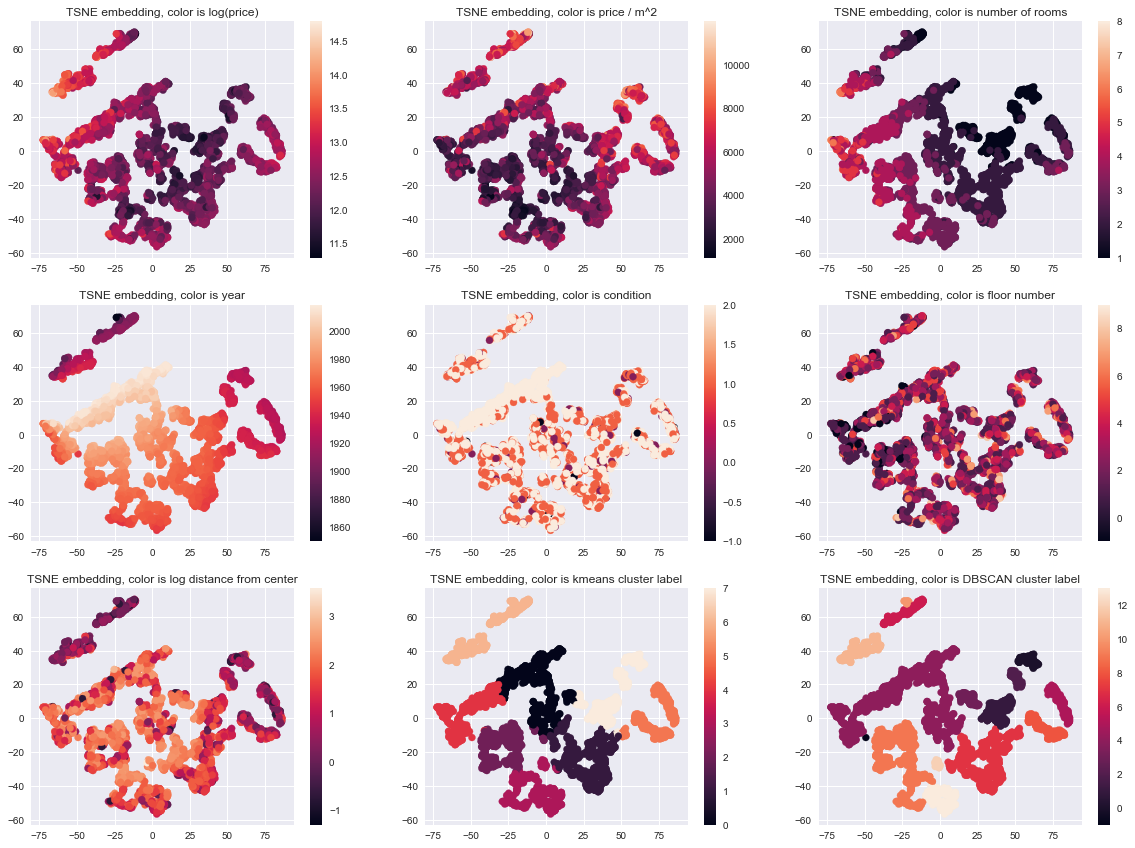

In [30]:
utils.tsne_plots(data_tsne_embedded, data, kmeans_labels, dbscan_labels)

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

Explained variance for the first two principal components:
0.9925895201960613


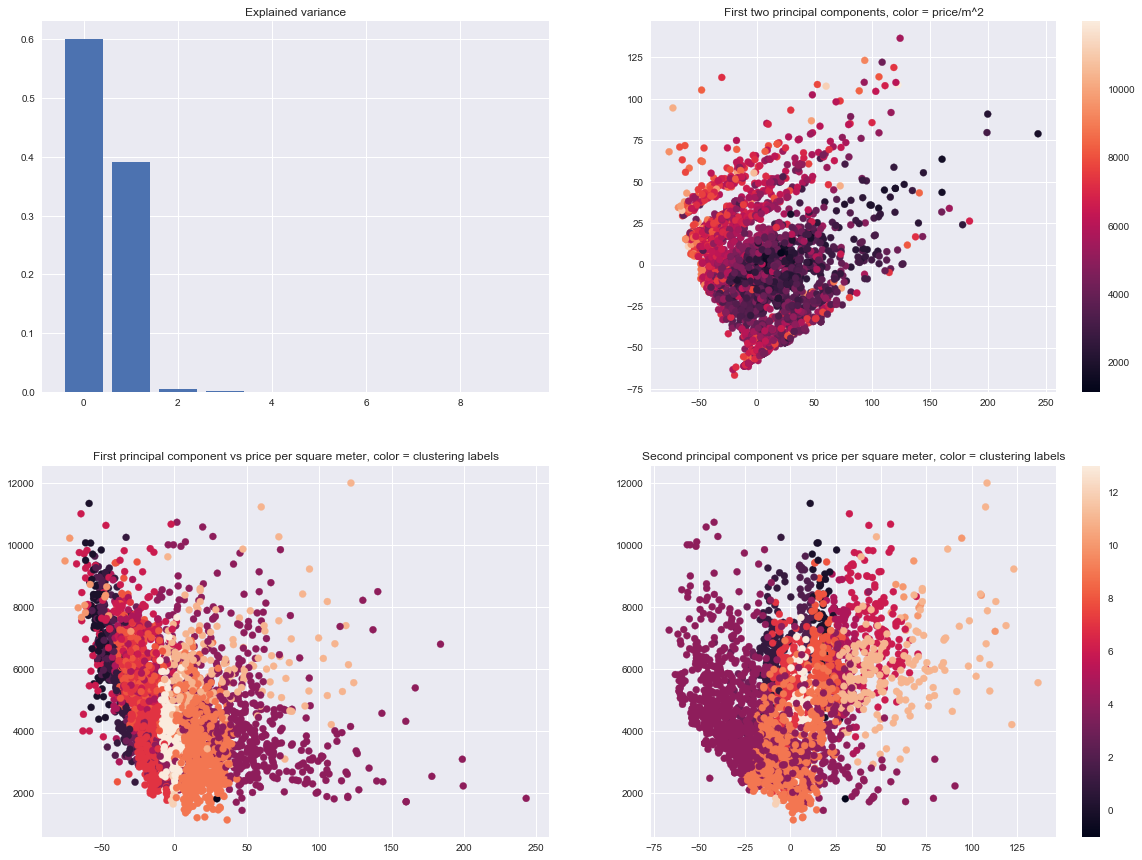

In [31]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

utils.pca_plots(data_pca_model, data_pca_embedded, data, dbscan_labels)

## GAUSSIAN PROCESS FIT

### Train-test split
We split the complete data to train and test sets. The test set is data from year 2000 onwards.

In [32]:
from sklearn.model_selection import train_test_split
# Split data to train and test sets
# Predict house prices after 2017
cutoff_year = 2000

train_data = data[data.year < cutoff_year]
test_data = data[data.year >= cutoff_year]
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)


print('Train and test set sizes:')
print(len(train_data), len(test_data))

Train and test set sizes:
2661 666


### Baseline predictions based on avarage neighborghhood price per square meter

In [116]:
train_neigh, test_neigh = train_test_split(data_with_neighborhood, test_size=0.33, random_state=42)

train_neigh = train_neigh[['neighborhood','price_per_square_meter']].groupby('neighborhood').mean()
res_neigh = neigh_test.join(train_neigh, lsuffix='', rsuffix='_pred', on='neighborhood')

predictions = res_neigh['price_per_square_meter_pred']
Y_test_b = res_neigh['price_per_square_meter']

mean_test_error = np.mean((Y_test_b-predictions)**2)
mean_abs_test_error = np.mean(abs((Y_test_b - predictions)))
print('\nMean squared test error:')
print(mean_test_error)
print('\nMean absolute test error:')
print(mean_abs_test_error)
print('\n')
res_neigh[['neighborhood','price_per_square_meter','price_per_square_meter_pred']].head(5)


Mean squared test error:
934263.649142

Mean absolute test error:
738.41298229




,neighborhood,price_per_square_meter,price_per_square_meter_pred
444,Kannelmäki,5707,3468.190476
2931,Ullanlinna,6872,7665.196429
3303,Siltamäki,2722,2672.800000
1106,Roihuvuori,4610,4043.829787
1475,Keski-Töölö,6563,6177.440000


### Baseline models

As a baseline to reach, we train kNN, Random Forest and linear regression models. We try to surpass the performance of these models with the GPs.
They both have similar MSEs, about 300 000. We can also look at the random forest's feature importances to see which features influence the decisions the most.

Distance from city center is the most important feature by far. Square meters and year are the next most important features. Other features contribute little if at all.

/u/07/akalervo/unix/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 445530.67
Mean absolute error: 458.27
Variance score: 0.87 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 971583.25
Mean absolute error: 695.80
Variance score: 0.72 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 1015362.90
Mean absolute error: 768.87
Variance score: 0.71 

RF feature importance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

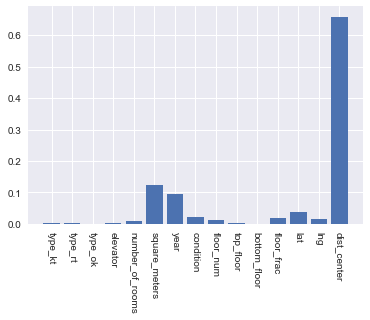

In [85]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X_train_b = train_data.drop(columns=['price', 'price_per_square_meter'])
Y_train_b = train_data[['price_per_square_meter']]

X_test_b = test_data.drop(columns=['price', 'price_per_square_meter'])
Y_test_b = test_data[['price_per_square_meter']]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()


for model in [rf, kn, ln]:
    model.fit(X_train_b, Y_train_b)
    print(model)
    predictions = model.predict(X_test_b)
    print("Mean squared error: %.2f" % mean_squared_error(Y_test_b, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test_b, predictions))
    print('Variance score: %.2f \n' % r2_score(Y_test_b, predictions))
    
print('RF feature importance')

plt.bar(range(0,15), rf.feature_importances_, tick_label = X_train_b.columns)
plt.xticks(rotation=-90)

### Baseline models for PCA data

In [87]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()


for model in [rf, kn, ln]:
    model.fit(pca_train_X, pca_train_Y)
    print(model)
    predictions = model.predict(pca_test_X)
    print("Mean squared error: %.2f" % mean_squared_error(pca_test_Y, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(pca_test_Y, predictions))
    print('Variance score: %.2f \n' % r2_score(pca_test_Y, predictions))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 1729966.81
Mean absolute error: 967.27
Variance score: 0.51 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 1696304.40
Mean absolute error: 971.99
Variance score: 0.52 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 2658709.31
Mean absolute error: 1301.88
Variance score: 0.24 



/u/07/akalervo/unix/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



## Linear regression

### Year built

In [89]:
from plotly.offline import iplot, init_notebook_mode, plot
import plotly.graph_objs as go
import plotly.offline as offline



init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

x_train = train_data[['year']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['year']]
y_test = test_data['price_per_square_meter']

ln = LinearRegression()

ln.fit(x_train, y_train)

y_pred = ln.predict(x_test)

# The coefficients
print('Coefficients: \n', ln.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
p1 = go.Scatter(x=x_test.values.flatten(), 
                y=y_test.values.flatten(), 
                mode='markers',
                marker=dict(color='black')
               )

p2 = go.Scatter(x=x_test.values.flatten(), 
                y=y_pred,
                mode='lines',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(xaxis=dict(ticks='', showticklabels=True,
                              zeroline=True),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=True),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p1, p2], layout=layout)


iplot(fig)


Coefficients: 
 [-24.79782477]
Mean squared error: 2860640.79
Mean absolute error: 1355.61
Variance score: 0.18


In [90]:
from plotly.offline import iplot, init_notebook_mode, plot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

x_train = train_data[['dist_center']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['dist_center']]
y_test = test_data['price_per_square_meter']

ln = LinearRegression()

ln.fit(x_train, y_train)

y_pred = ln.predict(x_test)

# The coefficients
print('Coefficients: \n', ln.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
p1 = go.Scatter(x=x_test.values.flatten(), 
                y=y_test.values.flatten(), 
                mode='markers',
                marker=dict(color='black')
               )

p2 = go.Scatter(x=x_test.values.flatten(), 
                y=y_pred,
                mode='lines',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(xaxis=dict(ticks='', showticklabels=True,
                              zeroline=True),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=True),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p1, p2], layout=layout)

iplot(fig)


Coefficients: 
 [-357.89069098]
Mean squared error: 1379211.58
Mean absolute error: 900.14
Variance score: 0.61


### GP for price prediction per year
Let's do this boys: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb
And some other stuff from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb

In [127]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s14  0004   6.473891e+08   2.677340e+16 
    14s78  0016   2.184457e+07   3.522834e+10 
    21s86  0024   2.240858e+06   2.037423e+07 
    23s62  0026   1.314812e+06   4.738632e+05 
    30s28  0034   1.730544e+05   1.780688e+02 
    36s63  0042   3.954423e+04   3.854717e+06 
    39s79  0046   3.088688e+04   2.276820e+00 
    43s27  0050   2.387683e+04   1.073029e+02 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



    44s35  0051   2.476800e+04           nan 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    46s11  0053   2.673900e+04           nan 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



    47s96  0055   2.387683e+04   1.073029e+02 
Runtime:     47s96
Optimization status: Converged


Name : GP regression
Objective : 23876.833382994068
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  383392.545678  |      +ve      |        
  rbf.lengthscale          |  93.0709323883  |      +ve      |        
  Gaussian_noise.variance  |  883474.586646  |      +ve      |        

Log marginal likelihood:
-23876.833383

Mean squared test error:
2154823.26693

MLPPD:
-8.98339688053
This is the format of your plot grid:
[ (1,1) x1,y1 ]



### GP for price prediction distance from the cener

In [92]:
X_train = train_data[['dist_center']]
Y_train = train_data[['price_per_square_meter']]

X_test = test_data[['dist_center']]
Y_test = test_data[['price_per_square_meter']]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.452457e+09           nan 
    03s50  0004   4.356055e+08   1.486846e+16 
    08s61  0010   7.897877e+07   1.306111e+13 
    16s13  0018   8.501400e+06   2.967702e+09 
    21s21  0024   2.687676e+06   2.158124e+07 
    27s62  0032   5.061292e+05   1.338348e+05 
    31s22  0036   2.580283e+05   5.419333e+06 
    36s53  0042   6.251929e+04   1.793671e+02 
    44s72  0051   2.592251e+04   1.419019e+03 
    54s91  0063   2.241012e+04   1.017213e-03 
 01m21s65  0094   2.234639e+04   3.760539e-01 
 01m41s09  0115   2.221618e+04   3.919856e-06 
Runtime:  01m41s09
Optimization status: Converged


Name : GP regression
Objective : 22216.18459549917
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   15296162.6206  |      +ve      |        
  rbf.le

TypeError: unhashable type: 'slice'

### GP for PCA data
As the first two principal components account for 99% of the variance, we fit a GP to this transform. Now the GP is two dimensional, which makes constructing kernels more difficult.

In [139]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

In [140]:
kernel = GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=1., lengthscale=1.) 
#kernel += GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=10., lengthscale=1.) 
#kernel += GPy.kern.Linear(input_dim=pca_train_X.shape[1])

m = GPy.models.GPRegression(pca_train_X, pca_train_Y, kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s13  0004   2.124951e+09   6.159937e+17 
    14s28  0016   3.688766e+07   3.839674e+11 
    19s41  0022   6.952952e+06   7.447104e+09 
    26s06  0030   7.355828e+05   8.887936e+05 
    33s06  0038   9.525093e+04   7.690068e+03 
    44s06  0050   2.836021e+04   8.436474e-02 
    52s70  0060   2.282023e+04   1.050671e-01 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply




    55s17  0063   2.282023e+04   1.050671e-01 
Runtime:     55s17
Optimization status: Converged



In [142]:
#Gpy.plotting.show(fig)
utils.model_information(m, pca_test_X, pca_test_Y, plot_test_data = False)


Name : GP regression
Objective : 22820.233551566995
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  689432.311499  |      +ve      |        
  rbf.lengthscale          |  45.1655236588  |      +ve      |        
  Gaussian_noise.variance  |  1575427.36301  |      +ve      |        

Log marginal likelihood:
-22820.2335516

Mean squared test error:
1608634.46707

MLPPD:
-8.56178129315
This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [78]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [79]:


slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [80]:
m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 10)

display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.427598e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

overflow encountered in expm1

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    01s91  0001   2.427598e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:

invalid value encountered in greater




    03s83  0002           nan           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:

invalid value encountered in greater

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



    08s44  0005           nan           nan 
    23s07  0015           nan           nan 
Runtime:     23s07
Optimization status: None

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 